In [214]:
import os
import numpy

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay


# Esto no lo tienen que poner
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [215]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(PATH)
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

C:\Users\marco\.keras\datasets\cats_and_dogs_filtered


In [216]:
BATCH_SIZE = 512
IMG_SIZE = (65, 65)
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)


(65, 65)
(65, 65, 3)


In [217]:

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 2000 files belonging to 2 classes.


In [218]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


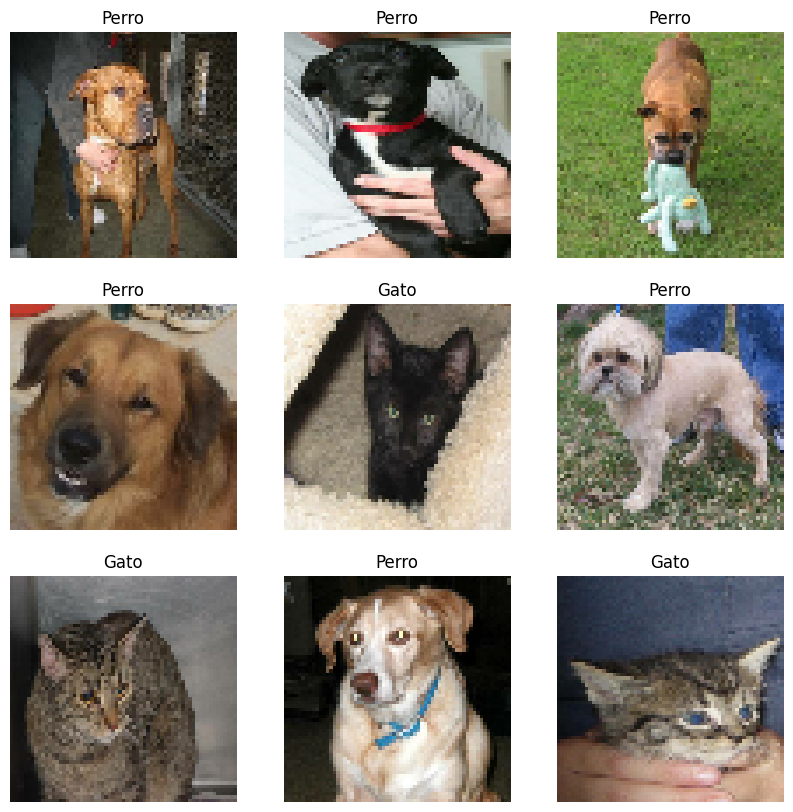

In [219]:
class_names = ["Gato", "Perro"]

plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [220]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [221]:
HIDDEN_UNITS = 512
EPOCHS = 50
LEARNING_RATE = 0.001  # 1e-2
OPTIMIZER = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)
LOSS = "binary_crossentropy"
METRICS = ["accuracy"]

In [222]:
rescale = layers.Rescaling(1./255)

In [223]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2)
])

In [224]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [225]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0] 
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [226]:
# inputs =  tf.keras.Input(shape=IMG_SHAPE)
# x = rescale(inputs)

# x = layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_uniform", padding="same")(x)
# x = layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_uniform", padding="same")(x)
# x = layers.MaxPooling2D((2,2))(x)
# # x = layers.Dropout(0.5)(x)

# x = layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_uniform", padding="same")(x)
# x = layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_uniform", padding="same")(x)
# x = layers.MaxPooling2D((2,2))(x)
# # x = layers.Dropout(0.5)(x)

# x = layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_uniform", padding="same")(x)
# x = layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_uniform", padding="same")(x)
# x = layers.MaxPooling2D((2,2))(x)
# # x = layers.Dropout(0.5)(x)

# x = layers.Flatten()(x)
# x = layers.Dense(HIDDEN_UNITS, activation="relu", kernel_initializer="he_uniform")(x)
# x = layers.Dropout(0.5)(x)

# outputs = layers.Dense(1, activation="sigmoid")(x)

# model  = tf.keras.Model(inputs, outputs)

In [239]:
base_model = tf.keras.applications.EfficientNetB7(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet"
)

preprocess_input = tf.keras.applications.EfficientNetB7.preprocess_input
base_model.trainable = False

258076736/258076736 [==============================] - 10s 0us/step


AttributeError: 'function' object has no attribute 'preprocess_input'

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 65, 65, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 71, 71, 3)    0           ['input_17[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 33, 33, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 33, 33, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = layers.Lambda(preprocess_input)(inputs)
x = base_model(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(HIDDEN_UNITS, activation='relu')(x)
x = layers.Dense(HIDDEN_UNITS, activation='relu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    verbose=1
)

Epoch 1/50
4/4 [==============================] - 9s 1s/step - loss: 18.9841 - accuracy: 0.5025 - val_loss: 8.8079 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 1s 372ms/step - loss: 4.6768 - accuracy: 0.4790 - val_loss: 3.3449 - val_accuracy: 0.5000
Epoch 3/50
4/4 [==============================] - 1s 368ms/step - loss: 1.5864 - accuracy: 0.5385 - val_loss: 0.7965 - val_accuracy: 0.6430
Epoch 4/50
4/4 [==============================] - 1s 363ms/step - loss: 0.8793 - accuracy: 0.6345 - val_loss: 0.3563 - val_accuracy: 0.8500
Epoch 5/50
4/4 [==============================] - 1s 396ms/step - loss: 0.5924 - accuracy: 0.7235 - val_loss: 0.3753 - val_accuracy: 0.8420
Epoch 6/50
4/4 [==============================] - 1s 373ms/step - loss: 0.5291 - accuracy: 0.7730 - val_loss: 0.4309 - val_accuracy: 0.8200
Epoch 7/50
4/4 [==============================] - 1s 375ms/step - loss: 0.4774 - accuracy: 0.7815 - val_loss: 0.3523 - val_accuracy: 0.8550
Epoch 8/50
4/4 [======

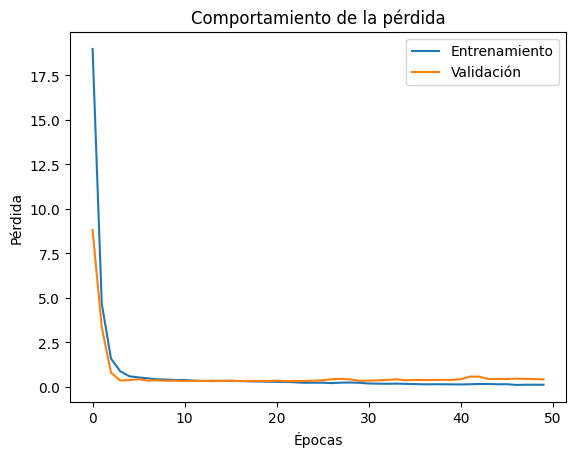

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Comportamiento de la pérdida")
plt.ylabel("Pérdida")
plt.xlabel("Épocas")
plt.legend(["Entrenamiento", "Validación"], loc="best")
plt.show()

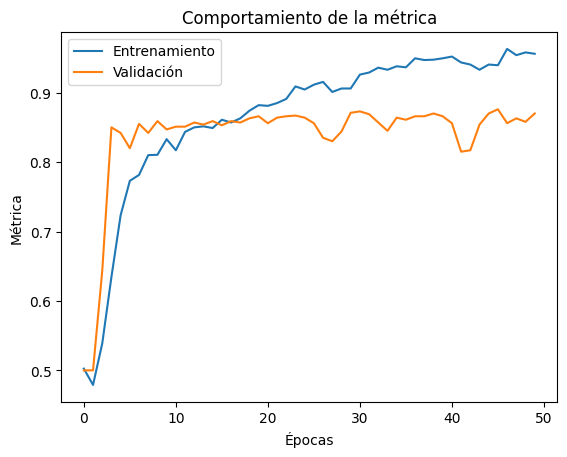

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Comportamiento de la métrica")
plt.ylabel("Métrica")
plt.xlabel("Épocas")
plt.legend(["Entrenamiento", "Validación"], loc="best")
plt.show()

In [ ]:
score = model.evaluate(validation_dataset)
print(f"Pérdida en prueba: {score[0]}")
print(f"Métrica en prueba: {score[1]}")

2/2 [==============================] - 0s 85ms/step - loss: 0.4185 - accuracy: 0.8700
Pérdida en prueba: 0.4184774160385132
Métrica en prueba: 0.8700000047683716


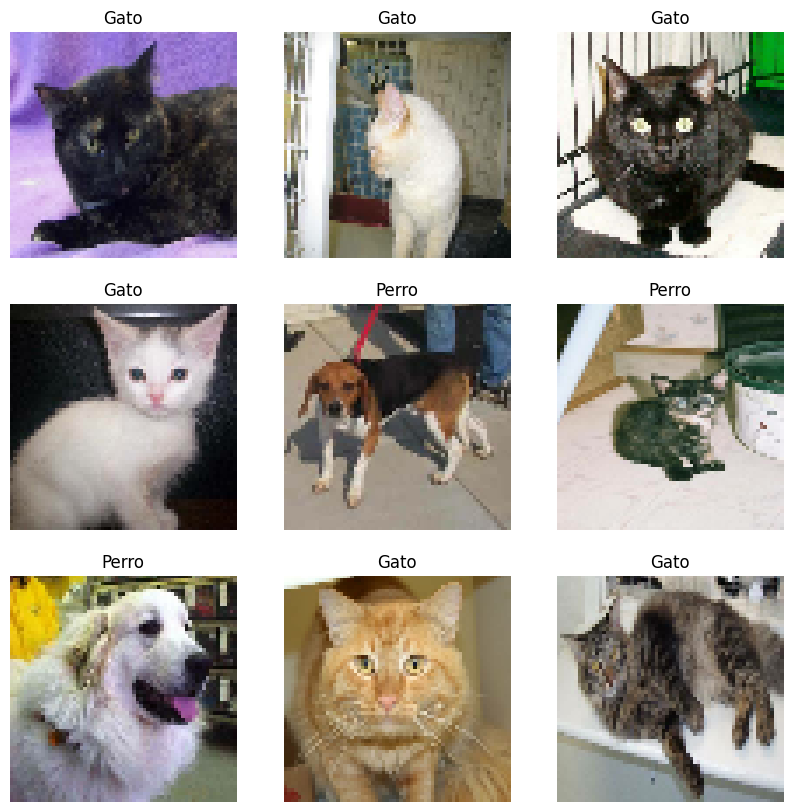

In [ ]:
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"{class_names[predictions[i]]}")
    plt.axis("off")

In [ ]:
print(classification_report(label_batch, predictions, target_names=class_names))

              precision    recall  f1-score   support

        Gato       0.90      0.85      0.87       269
       Perro       0.84      0.89      0.87       243

    accuracy                           0.87       512
   macro avg       0.87      0.87      0.87       512
weighted avg       0.87      0.87      0.87       512



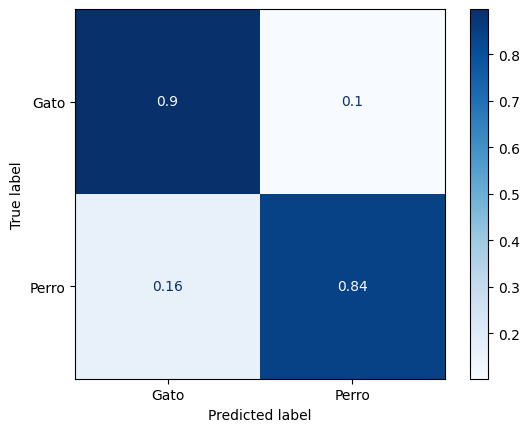

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(predictions, label_batch, normalize="true", display_labels=class_names, cmap="Blues")

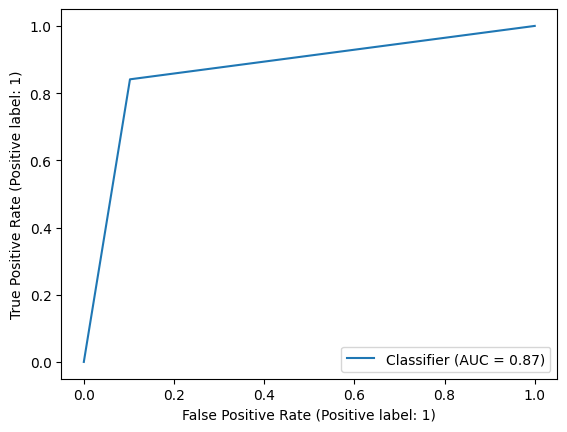

In [ ]:
disp = RocCurveDisplay.from_predictions(predictions, label_batch)
